In [1]:
%load_ext autoreload
%autoreload 2

In [151]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, ConnectionPatch
import matplotlib.transforms as mplt
import models
import mscthesis
from sklearn.metrics.pairwise import haversine_distances
import numpy as np
import pandas as pd
import geopandas as gpd

In [195]:
geotweets = mscthesis.read_geotweets('sweden').set_index('userid')

In [196]:
tweetcount = geotweets.groupby('userid').size()
geotweets = geotweets.drop(labels=tweetcount[tweetcount < 10].index)

# Distance v Probabilty

In [197]:
def distance_vs_probability(tweets):
    home = tweets[tweets['label'] == 'home']
    if home.shape[0] > 1:
        home = home.iloc[0]
    region_counts = tweets.groupby('region').size()
    region_probs = region_counts / region_counts.sum()
    regions = tweets.groupby('region').head(1).set_index('region').sort_index()
    distances_km = pd.Series(
        (6371.0088 * haversine_distances(
            np.radians(regions[['latitude', 'longitude']]),
            np.radians([[home.latitude, home.longitude]]),
        ))[:,0],
        index=regions.index,
    )
    return pd.DataFrame.from_dict(dict(
        distance = distances_km,
        probability = region_probs
    ))

In [198]:
distances_from_home = []
for uid in geotweets.index.get_level_values(level=0).unique():
    tweets = geotweets.loc[uid]
    if tweets.shape[0] < 2:
        continue
    distances_from_home.append(distance_vs_probability(tweets).assign(userid=uid))
distances_from_home = pd.concat(distances_from_home).reset_index().set_index(['userid', 'region'])

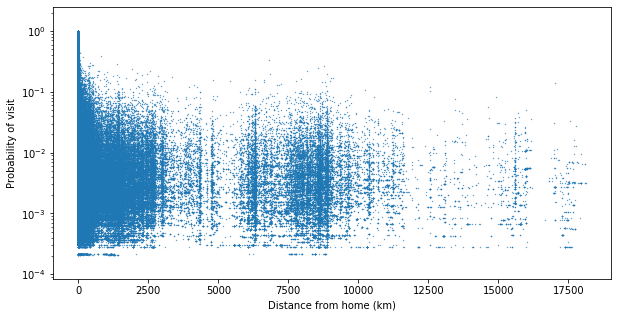

In [199]:
fig, ax = plt.subplots(figsize=(10,5))
plt.xlabel("Distance from home (km)")
plt.ylabel("Probability of visit")
ax.set_yscale("log")
_ = ax.scatter(distances_from_home.distance, distances_from_home.probability, s=0.1)

# Sampers bounding boxes

In [33]:
import sampers
import regions

In [171]:
westbbox = regions.gbgcity.to_crs("EPSG:3035")
westzones = sampers.read_shp(sampers.shps['west']).to_crs("EPSG:3035")
westzones = westzones[westzones.geometry.is_valid]
westzones = gpd.clip(
    westzones,
    gpd.GeoDataFrame(geometry=westbbox),
)

eastbbox = regions.sthlmcity.to_crs("EPSG:3035")
eastzones = sampers.read_shp(sampers.shps['east']).to_crs("EPSG:3035")
esatzones = eastzones[eastzones.geometry.is_valid]
eastzones = gpd.clip(
    eastzones,
    gpd.GeoDataFrame(geometry=eastbbox),
)

/Users/ericwennerberg/opt/miniconda3/envs/mscthesis/lib/python3.8/site-packages/geopandas/geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
/Users/ericwennerberg/opt/miniconda3/envs/mscthesis/lib/python3.8/site-packages/geopandas/geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPanda

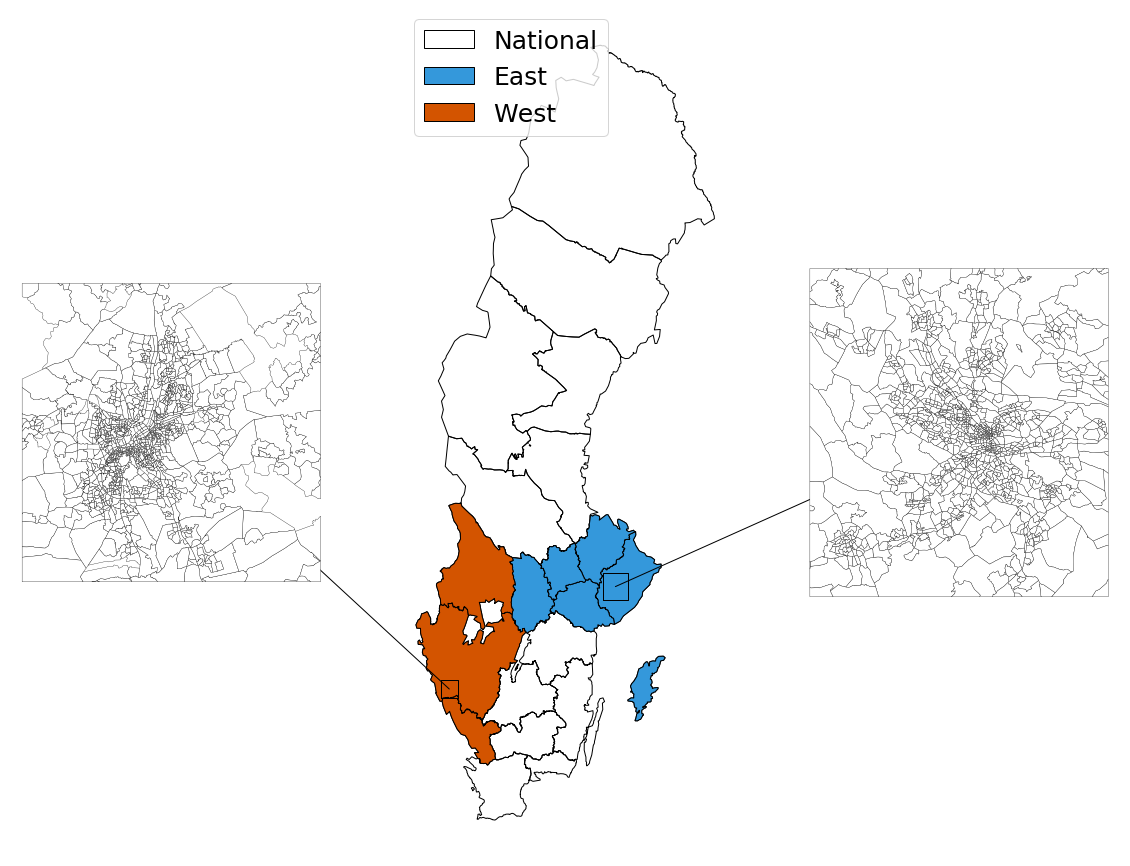

In [192]:
fig, axes = plt.subplots(1,3, figsize=(20, 20))
sampers.bbox['national'].to_crs("EPSG:3035").plot(
    ax=axes[1],
    edgecolor='black', 
    facecolor='none', 
)
sampers.bbox['east'].to_crs("EPSG:3035").plot(
    ax=axes[1],
    facecolor='#3498db',
    edgecolor='black',
)
sampers.bbox['west'].to_crs("EPSG:3035").plot(
    ax=axes[1], 
    facecolor='#d35400',
    edgecolor='black'
)

regions.sthlmcity.to_crs("EPSG:3035").plot(ax=axes[1], facecolor='none', edgecolor='black')
regions.gbgcity.to_crs("EPSG:3035").plot(ax=axes[1], facecolor='none', edgecolor='black')

axes[1].add_artist(ConnectionPatch(
    xyA=(eastbbox.centroid.x, eastbbox.centroid.y),
    xyB=(eastbbox.centroid.x, eastbbox.centroid.y),
    coordsA="data",
    coordsB="data",
    axesA=axes[1],
    axesB=axes[2],
    color='black',
    linewidth=1,
))

axes[1].add_artist(ConnectionPatch(
    xyA=(westbbox.centroid.x, westbbox.centroid.y),
    xyB=(westbbox.centroid.x, westbbox.centroid.y),
    coordsA="data",
    coordsB="data",
    axesA=axes[0],
    axesB=axes[1],
    color='black',
    linewidth=1,
))


eastzones.plot(ax=axes[2], facecolor='white', edgecolor='black', linewidth=0.3)
westzones.plot(ax=axes[0], facecolor='white', edgecolor='black', linewidth=0.3)

axes[0].set_axis_off()
axes[0].zorder = 2

axes[1].set_axis_off()
axes[1].zorder = 1

axes[2].set_axis_off()
axes[2].zorder = 2

axes[1].legend(
    handles=[
        Patch(facecolor='none', edgecolor='black', label='National'),
        Patch(facecolor='#3498db', edgecolor='black', label='East'),
        Patch(facecolor='#d35400', edgecolor='black', label='West')
    ], 
    loc='upper left',
    fontsize='25'
)